## 실습 및 자습
https://wikidocs.net/44249
네이버 영화 리뷰 감성 분류

In [1]:
# konlpy 라이브러리 설치
!pip install konlpy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1) 데이터 로드하기
위 링크로부터 훈련 데이터에 해당하는 ratings_train.txt와 테스트 데이터에 해당하는 ratings_test.txt를 다운로드합니다.

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fa7b9eead10>)

In [4]:
# pandas를 이용하여 훈련 데이터는 train_data에 테스트 데이터는 test_data에 저장합니다.
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

# train_data에 존재하는 영화 리뷰의 개수를 확인해봅시다.
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
# 훈련용 리뷰 개수 : 150000
# train_data는 총 150,000개의 리뷰가 존재합니다. 상위 5개의 샘플을 출력해봅시다.

train_data[:5] # 상위 5개 출력

훈련용 리뷰 개수 : 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력
# 테스트용 리뷰 개수 : 50000

테스트용 리뷰 개수 : 50000


In [6]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [7]:
# train_data의 데이터 중복 유무를 확인합니다.
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()
# (146182, 2)

(146182, 2)

In [8]:
# 총 150,000개의 샘플이 존재하는데 document열에서 중복을 제거한 샘플의 개수가 146,182개라는 것은 
# 약 4,000개의 중복 샘플이 존재한다는 의미입니다. 
# label 열은 0 또는 1의 두 가지 값만을 가지므로 2가 출력됩니다. 중복 샘플을 제거합니다.

# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
# 중복 샘플을 제거하였습니다. 중복이 제거되었는지 전체 샘플 수를 확인합니다.

print('총 샘플의 수 :',len(train_data))
# 총 샘플의 수 : 146183

총 샘플의 수 : 146183


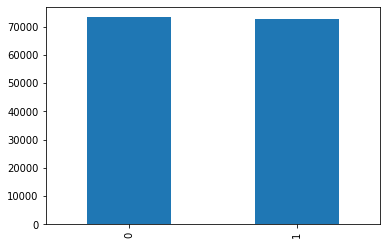

In [9]:
# train_data에서 해당 리뷰의 긍, 부정 유무가 기재되어있는 레이블(label) 값의 분포를 보겠습니다.
train_data['label'].value_counts().plot(kind = 'bar')

In [10]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [11]:
# NULL 값이 존재하는 데이터를 찾아본다.
print(train_data.isnull().values.any())
print(train_data.isnull().sum())

True
id          0
document    1
label       0
dtype: int64


In [12]:
# 리뷰가 적혀있는 document 열에서 Null 값을 가진 샘플이 총 1개가 존재한다고 합니다. 
# 그렇다면 document 열에서 Null 값이 존재한다는 것을 조건으로 Null 값을 가진 샘플이 
# 어느 인덱스의 위치에 존재하는지 한 번 출력해봅시다.

train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [13]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [14]:
# Null 값을 가진 샘플이 제거되었습니다. 
# 샘플의 개수를 출력하여 1개의 샘플이 제거되었는지 확인해봅시다.

print(len(train_data))
# 146183 -> 146182로 되었다.

146182


In [15]:
# 데이터의 전처리를 수행해보겠습니다. 위의 train_data와 test_data에서 온점(.)이나 ?와 같은 각종 특수문자가 사용된 것을 확인했습니다. 
# train_data로부터 한글만 남기고 제거하기 위해서 정규 표현식을 사용해보겠습니다.

# 우선 영어를 예시로 정규 표현식을 설명해보겠습니다. 영어의 알파벳들을 나타내는 정규 표현식은 [a-zA-Z]입니다. 
# 이 정규 표현식은 영어의 소문자와 대문자들을 모두 포함하고 있는 정규 표현식으로 이를 응용하면 
# 영어에 속하지 않는 구두점이나 특수문자를 제거할 수 있습니다. 
# 예를 들어 알파벳과 공백을 제외하고 모두 제거하는 전처리를 수행하는 예제는 다음과 같습니다.

#알파벳과 공백을 제외하고 모두 제거
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))
# 'do you expect people to read the FAQ etc and actually accept hard atheism' 결과가 나오게 됩니다.

do you expect people to read the FAQ etc and actually accept hard atheism


In [16]:
# 한글과 공백을 제외하고 모두 제거
display(train_data[:5])
print("한글 및 공백을 제외하고 모두 제거")
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
display(train_data[:5])

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


한글 및 공백을 제외하고 모두 제거


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [17]:
# 네이버 영화 리뷰는 한글이 아니더라도 영어, 숫자, 특수문자로도 리뷰를 업로드할 수 있습니다. 
# 다시 말해 기존에 한글이 없는 리뷰였다면 더 이상 아무런 값도 없는 빈(empty) 값이 되었을 것입니다. 
# train_data에 공백(whitespace)만 있거나 빈 값을 가진 행이 있다면 Null 값으로 변경하도록 하고, 
# Null 값이 존재하는지 확인해보겠습니다.

train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


id            0
document    789
label         0
dtype: int64


In [18]:
#  Null 값이 있는 행을 5개만 출력해볼까요?

train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [19]:
# Null 샘플들은 레이블이 긍정일 수도 있고, 부정일 수도 있습니다. 
# 아무런 의미도 없는 데이터므로 제거해줍니다.

train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [20]:
# 테스트 데이터에 앞서 진행한 전처리 과정을 동일하게 진행합니다.

test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


전처리 후 테스트용 샘플의 개수 : 48852


## 3) 토큰화
토큰화를 진행해봅시다. 토큰화 과정에서 불용어를 제거하겠습니다. 불용어는 정의하기 나름인데, 한국어의 조사, 접속사 등의 보편적인 불용어를 사용할 수도 있겠지만 결국 풀고자 하는 문제의 데이터를 지속 검토하면서 계속해서 추가하는 경우 또한 많습니다. 실제 현업인 상황이라면 일반적으로 아래의 불용어보다 더 많은 불용어를 사용할 수 있습니다.

In [22]:
# 여기서는 위 정도로만 불용어를 정의하고, 토큰화를 위한 형태소 분석기는 
# KoNLPy의 Okt를 사용합니다. Okt를 복습해봅시다.
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)
# ['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [23]:
# train_data에 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 X_train에 저장합니다.

X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)
    
# 상위 3개의 샘플만 출력하여 결과를 확인해봅시다.
print(X_train[:3])

100%|██████████| 145393/145393 [09:28<00:00, 255.57it/s]

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [24]:
# 형태소 토큰화가 진행된 것을 볼 수 있습니다. 테스트 데이터에 대해서도 동일하게 토큰화를 해줍니다.

X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [03:53<00:00, 209.26it/s]
